## Oxygen above 20 m

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [10]:
def plot_and_stats(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 400
    vmin = 100
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1['Oxygen_Dissolved'][(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_dissolved_oxygen[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 5), norm=LogNorm());
#    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Oxygen_Dissolved', 'mod_dissolved_oxygen')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Oxygen_Dissolved', 'mod_dissolved_oxygen')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'Oxygen_Dissolved', 'mod_dissolved_oxygen')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Oxygen_Dissolved', 'mod_dissolved_oxygen')
    tspread = spread(temp1[temp1.k >= idepth], 'Oxygen_Dissolved', 'mod_dissolved_oxygen')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(5, 30, 0, 2-np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 34, 0, -2+np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 30, 0, 2-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 34, 0, -2+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 29, 0, 3-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 35, 0, -3+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(5-0.6, 26, 'bias', rotation=90)
    ax.text(7-0.6, 22, 'systematic', rotation=90)
    ax.text(9-0.6, 19, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Dissolved Oxygen above 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [12]:
pieces = ('/home/sallen/202007/H201812/ObsModel_201812_Bio_20150101-20151231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_201812_Bio_20160101-20161231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_201812_Bio_20170101-20171231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_201812_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20170101-20171231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_H201812_pug_20150101_20151231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_H201812_pug_20160101_20161231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_H201812_pug_20170101_20171231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20150101_20151231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20160101_20161231.csv',
  #       '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20170101_20171231.csv')
         )

In [14]:
temp1 = read_pieces(pieces)
temp1.keys()

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure',
       'Depth', 'Ammonium', 'Ammonium_units', 'Chlorophyll_Extracted',
       'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal',
       'ConsT', 'Z', 'dtUTC', 'j', 'i', 'mod_nitrate', 'mod_silicon',
       'mod_ammonium', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates',
       'mod_vosaline', 'mod_votemper', 'k'],
      dtype='object')

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2940,-1.5,3.5,0.13,0.14,2.0,1.7,3.1,-0.16


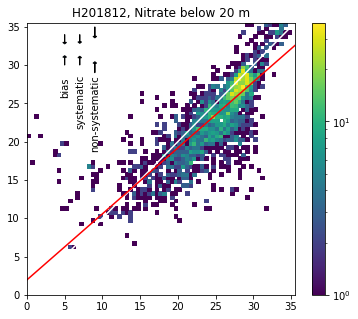

In [13]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
idepth = 19
jdepth = 39
d201812 = plot_and_stats(temp1, 'H201812', idepth, jdepth)
d201812.style.format(myformat)

In [14]:
pieces = ('/home/sallen/202007/H201905/ObsModel_201905_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,2940,-1.5,3.3,0.14,0.33,6.8,2.2,2.4,0.31


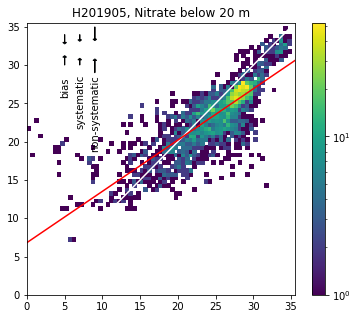

In [15]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
idepth = 19
jdepth = 39
d201905 = plot_and_stats(temp1, 'H201905', idepth, jdepth)
d201905.style.format(myformat)

In [11]:
pieces = ('/data/sallen/results/MEOPAR/202111/ObsModel_202111_bot_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psf_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pug_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_hplc_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_bot_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psf_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pug_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_hplc_20160101_20161231.csv')

0.5000002726327963 19.48178513731196


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v202111,534,-9.9,3.1e+01,0.04,0.27,5.9e+01,1.8e+01,2.5e+01,0.09


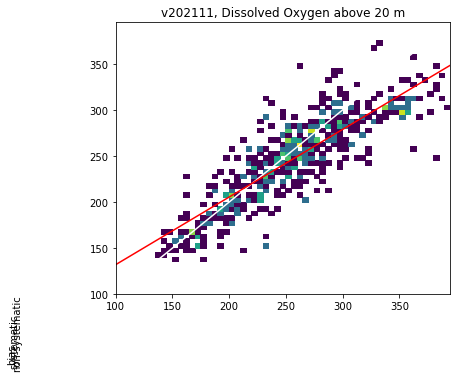

In [12]:
temp1 = read_pieces(pieces)
idepth = 0
jdepth = 18
v202111 = plot_and_stats(temp1, 'v202111', idepth, jdepth)
v202111.style.format(myformat)

In [ ]:
alltogether = pd.concat([d201812, d201905, dCp2, modCp3, Dagain, DnoC, DlowR, modF, modH, modGp1, modGp2], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2940,-1.5,3.5,0.13,0.14,2.0,1.7,3.1,-0.16
H201905,2940,-1.5,3.3,0.14,0.33,6.8,2.2,2.4,0.31
Cp2,2940,-2.2,3.6,0.15,0.24,3.8,2.5,2.6,0.13
Cp3,2936,-2.3,3.7,0.15,0.23,3.7,2.5,2.6,0.12
Dagain,2940,-1.7,3.3,0.14,0.32,6.5,2.3,2.3,0.31
D-noCil,2938,-2.2,3.6,0.14,0.25,4.1,2.5,2.6,0.16
D-lowR,2938,-1.6,3.2,0.14,0.33,6.8,2.3,2.3,0.32
F,2938,-1.8,3.4,0.15,0.32,6.3,2.4,2.4,0.29
H,2938,-1.8,3.4,0.13,0.27,5.0,2.2,2.6,0.19
Gp1,2938,-1.5,3.2,0.13,0.3,6.0,2.1,2.4,0.26
